In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from os.path import join
pt=1./72.27
textwidth=345.*pt
golden = (1 + 5 ** 0.5) / 2
plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("../paper.mplstyle")
std_figsize = (.45*textwidth,.45*textwidth/golden)
std_longfig= (.45*textwidth,.45*textwidth*golden)
large_longfig = (.9*textwidth,.9*textwidth*golden)
large_figsize =  (0.9*textwidth,0.9*textwidth/golden)
large_rot_figsize = (0.9*textwidth*golden,0.9*textwidth)
fig_direc = "C:\\Users\\amcsween\\Documents\\GitHub\\SpinDoctor\\microglia_figures_new"
# os.mkdir(fig_direc)
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [80]:
def plot_cell(file,figname=None):
    data = scipy.io.loadmat(file)
    signal = data['signal'].flatten()
    signal_um = data['signal_um'].flatten()
    bvals = data['bvals'].reshape(signal.shape)
    
    
    fig = plt.figure(figsize=std_longfig)
    ax = fig.add_subplot()
    
    ax.plot(bvals,signal,label='Our method',marker='x')
    ax.plot(bvals,signal_um,label='Modified ultraliser',marker='+',linestyle='dotted')
    
    ax.legend(loc='best')
    ax.set_ylim((0,1))
    ax.set_ylabel('Volume weighted signal')
    ax.set_xlabel('$b$ s/mm$^2$')
    plt.show()
    
    if figname is not None:
        fig.savefig(join(fig_direc,figname.replace('.','_')))

def plot_segmented_cell(file,figsize=large_figsize,figname=None):
    data = scipy.io.loadmat(file)
    soma_signal = data['signal_soma'].flatten()
    soma_signal_ultraliser = data['signal_soma_um'].flatten()
    process_signals = data['process_signals']
    process_signals_um = data['process_signals_um']
    bvals = data['bvals'].flatten()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.plot(bvals,soma_signal,marker='x',color=line_colors[0])
    ax.plot(bvals,soma_signal_ultraliser,marker='+', linestyle='dotted',color=line_colors[0])
    ndendrites = int(len(process_signals.flatten())//len(bvals))
    for i in range(0,ndendrites):
        ax.plot(bvals,process_signals[i,:],marker='x',color=line_colors[i+1])
        ax.plot(bvals,process_signals_um[i,:],marker='+', linestyle='dotted',color=line_colors[i+1])

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=line_colors[i], lw=1) for i in range(0,ndendrites+1)]
    custom_lines.append(Line2D([0], [0],marker='x', color='k', lw=1))
    custom_lines.append(Line2D([0], [0],marker='+', color='k',linestyle='dotted', lw=1))

    labels = ['Soma']
    labels.extend([f'Process {i+1}' for i in range(0,ndendrites)])
    labels.append('Our method')
    labels.append('Modified Ultraliser')
    ax.legend(custom_lines, labels,loc='best')
    # ax.legend(loc='best')
    ax.set_ylim((0,1))
    ax.set_ylabel('Volume weighted signal')
    ax.set_xlabel('$b$ s/mm$^2$')
    plt.show()
    if figname is not None:
        fig.savefig(join(fig_direc,figname.replace('.','_')))

def plot_segmented_errors(file,includecell= False,figsize=large_figsize,figname=None,rel=False):
    data = scipy.io.loadmat(file)
    soma_signal = data['signal_soma'].flatten()
    soma_signal_ultraliser = data['signal_soma_um'].flatten()
    process_signals = data['process_signals']
    process_signals_um = data['process_signals_um']
    bvals = data['bvals'].flatten()
    if rel:
        soma_errors = abs(soma_signal - soma_signal_ultraliser)/soma_signal
        dend_errors = abs(process_signals - process_signals_um)/process_signals_um
    else:
        soma_errors = abs(soma_signal - soma_signal_ultraliser)
        dend_errors = abs(process_signals - process_signals_um)
        
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    if includecell:
        data = scipy.io.loadmat(file.replace('_seg.mat','.mat'))
        signal = data['signal'].flatten()
        signal_ultraliser = data['signal_um'].flatten()
        if rel:
            cell_errors = abs(signal - signal_ultraliser)/signal
        else:
            cell_errors = abs(signal - signal_ultraliser)
        ax.plot(bvals,cell_errors,label='Cell',marker='o')
    ax.plot(bvals,soma_errors,label='Soma',marker='o')
    ndendrites = int(len(process_signals.flatten())//len(bvals))
    if ndendrites >1:
        for i in range(0,ndendrites):
            ax.plot(bvals,dend_errors[i,:],label=f'Process {i+1}',marker='o')
    else:
        ax.plot(bvals,dend_errors,label=f'Process 1',marker='o')

    ax.legend(loc='best')
    # ax.set_ylim((0,1))
    ax.set_ylabel('Volume weighted signal error')
    ax.set_xlabel('$b$ s/mm$^2$')
    if rel:
        ax.set_yscale('log')
        max_soma = max(soma_errors)
        min_soma = min(soma_errors)
        max_dend = max(dend_errors.flatten())
        min_dend = min(dend_errors.flatten())
        if includecell:
            max_cell = max(cell_errors)
            min_cell = min(cell_errors)
            max_soma = max(max_soma,max_cell)
            min_soma = min(min_cell,min_soma)    
        y_max = np.floor(np.log10(max(max_soma,max_dend))) +1 

        y_min = np.floor(np.log10(min(min_soma,min_dend))) 
        ax.set_ylim((10**y_min,10**y_max))
    plt.show()
    if figname is not None:
        fig.savefig(join(fig_direc,figname.replace('.','_')))

def plot_componentwise_average(file,figsize=large_figsize,figname=None):
    
    data = scipy.io.loadmat(file.replace('_seg',''))
    signal = data['signal'].flatten()
    signal_ultraliser = data['signal_um'].flatten()
    bvals = data['bvals'].reshape(signal.shape)

    data = scipy.io.loadmat(file)
    cmpt_avg = data['cmpt_avg'].flatten()
    cmpt_avg_um = data['cmpt_avg_um'].flatten()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    
    ax.plot(bvals,signal,label='Our method',marker='x')
    ax.plot(bvals,signal_ultraliser,label='Modified ultraliser',marker='+',linestyle='dotted')
    ax.plot(bvals,cmpt_avg_um,label='Modified Ultraliser\n(from components)',marker='D',linestyle='dashed')
    ax.plot(bvals,cmpt_avg,label='Our method\n(from components)',marker='.',linestyle='dashdot')

    ax.legend(loc='best')
    ax.set_ylim((0,1))
    ax.set_ylabel('Volume weighted signal')
    ax.set_xlabel('$b$ s/mm$^2$')
    plt.show()
    
    if figname is not None:
        fig.savefig(join(fig_direc,figname.replace('.','_')))


In [32]:
file = r'C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\826_6_3_seg.mat'
data = scipy.io.loadmat(file)

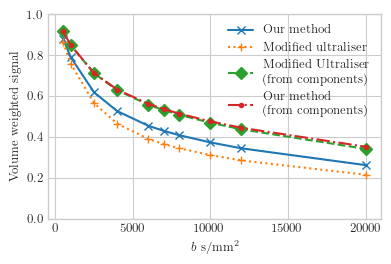

In [34]:
plot_componentwise_average(file)

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\714_3_2_seg.mat


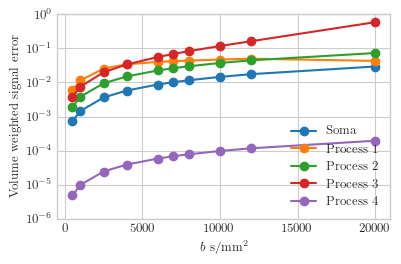

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\714_3_3_seg.mat


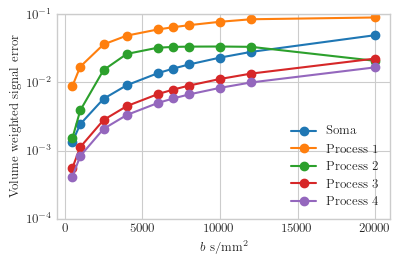

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\766_4_3_seg.mat


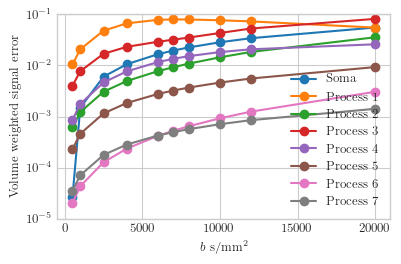

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\818_1_3_seg.mat


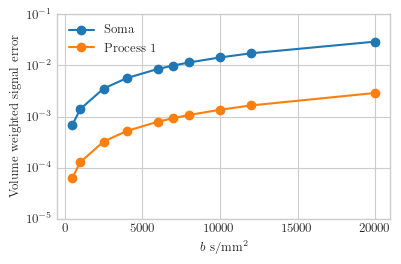

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\826_6_3_seg.mat


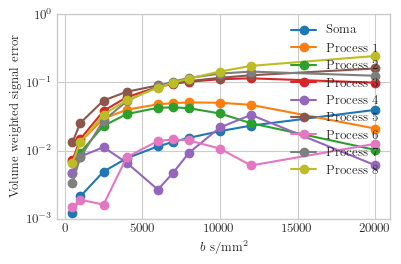

C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output\ctrl_010319_13_826-2_1_seg.mat


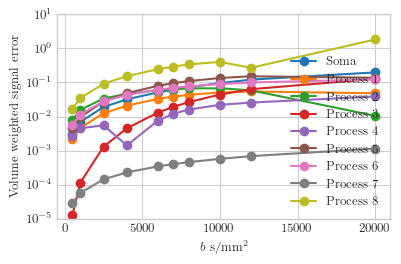

In [84]:
dirname = r"C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output"
dir = os.listdir(dirname)
for file in dir:
    file = os.path.join(dirname,file)
    if not('ctrl_210219_10_781-5_1' in file):
        if file.endswith('_seg.mat'):
            print(file)
            # plot_componentwise_average(file)
            plot_segmented_errors(file,includecell=False,rel=True)

714_3_2_seg.mat


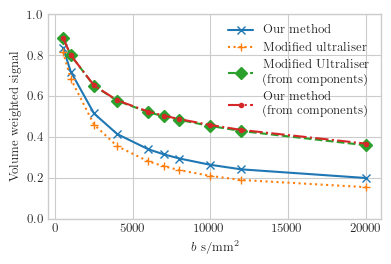

714_3_3_seg.mat


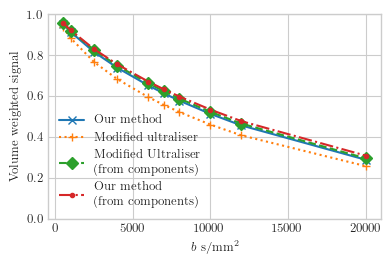

766_4_3_seg.mat


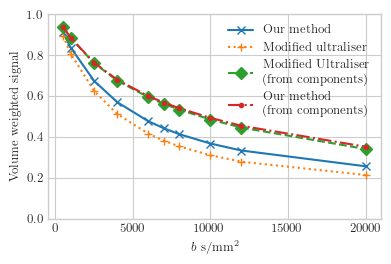

818_1_3_seg.mat


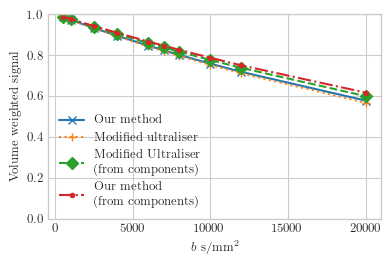

826_6_3_seg.mat


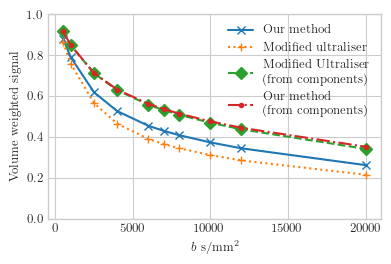

ctrl_010319_13_826-2_1_seg.mat


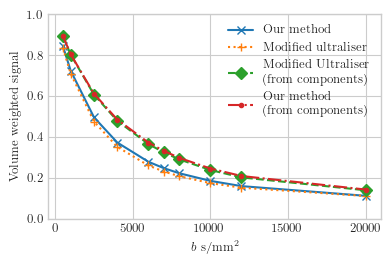

In [83]:
dirname = r"C:\Users\amcsween\Documents\GitHub\SpinDoctor\neuron_meshing_paper\microglia_output"
dir = os.listdir(dirname)
for file in dir:
    if not('ctrl_210219_10_781-5_1' in file):
        if file.endswith('_seg.mat'):
            print(file)
            plot_componentwise_average(os.path.join(dirname,file),figsize=large_figsize,figname=os.path.basename(file).replace('_seg.mat','_cell_signals'))